In [1]:

!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

In [2]:
!nvidia-smi


Thu Dec  9 15:51:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torchvision.models as models


In [ ]:
import os
import zipfile
import matplotlib
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import sys
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
from glob import glob 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
#Keras
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input #
from tensorflow.keras.optimizers import Adam, Adamax, Adadelta, Nadam, RMSprop
from keras.applications.inception_resnet_v2 import InceptionResNetV2 #
from keras.applications.xception import Xception #
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras import backend as K
#sklearn helpers
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing

In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2 #
from keras.applications.mobilenet_v3 import MobileNetV3, MobileNetV3Large, MobileNetV3Small
from keras.applications.resnet_v2 import ResNet152V2, ResNet50V2, ResNet101V2 #
from keras.applications.densenet import DenseNet201, DenseNet169, DenseNet121, DenseNet121 # 
from keras.applications.resnet import ResNet50, ResNet101, ResNet152 #
from keras.applications.efficientnet import EfficientNetB7, EfficientNetB6 #
from keras.applications.nasnet import NASNetLarge, NASNetMobile # NASNet - Large 00
from keras.applications.vgg19 import VGG19 #
from keras.applications.vgg16 import VGG16 #

In [ ]:
#Download the file and save it in a temporary placeholder '/tmp'
!wget --no-check-certificate \
  https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip \
  -O /tmp/cassavaleafdata.zip

#Unzip the file in '/tmp'
local_zip = '/tmp/cassavaleafdata.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

#Split the data into train, valid, test folders
base_dir = '/tmp/cassavaleafdata'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

--2021-12-07 07:01:55--  https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.5.128, 74.125.133.128, 74.125.140.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.5.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1354096203 (1.3G) [application/octet-stream]
Saving to: ‘/tmp/cassavaleafdata.zip’

/tmp/cassavaleafdat 100%[===================>]   1.26G   199MB/s    in 6.5s    

2021-12-07 07:02:02 (198 MB/s) - ‘/tmp/cassavaleafdata.zip’ saved [1354096203/1354096203]



In [ ]:
def preprocess(directory):
  '''
  Return the standardized format of all the 
  images in a given directory (ex: 'train', 'test', 'valid')
  '''
  image_files = list(paths.list_images(directory))
  #data and label placeholders
  arrays, labels = [], []
  cnt = 0
  for img in image_files:
    #find the label of the file
    label = img.split('/')[-2]
    # standardize the images: convert to RGB & resize to (224, 224)
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    #add the image and label to the place holders
    arrays.append(image)
    labels.append(label)
    cnt += 1
  #convert these to numpy arrays  
  arrays = np.array(arrays, dtype="float32")
  labels = np.array(labels)
 
  return arrays, labels

In [ ]:
#a placeholder for training data and the training labels
train_data, train_labels = preprocess(train_dir)
#a placeholder for validation (dev) data and the validation (dev) labels
valid_data, valid_labels = preprocess(valid_dir)
#a placeholder for test data and the test labels
test_data, test_labels = preprocess(test_dir)

In [ ]:
Binarizer = LabelBinarizer()
train_y = Binarizer.fit_transform(train_labels)
valid_y = Binarizer.transform(valid_labels)
test_y = Binarizer.transform(test_labels)

In [ ]:
#shuffling the training data
train_indx = np.arange(len(train_labels))
np.random.shuffle(train_indx)
train_data, train_y = train_data[train_indx], train_y[train_indx]

In [ ]:
#rescaling the images such that the pixel values are between one and zero
train_data = train_data / 255.
valid_data = valid_data / 255.
test_data = test_data / 255.

In [ ]:
train_augment = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

valid_augment = ImageDataGenerator()

train_augment.fit(train_data)
valid_augment.fit(valid_data)

In [ ]:
baseM6 = ResNet152(weights="imagenet", include_top=False, input_shape = (224, 224, 3)) ## 224, 224 size
#Freeze the Inception V3 layers:
for layer in baseM6.layers:
	layer.trainable = False

x = baseM6.output
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation="softmax")(x)

234708992/234698864 [==============================] - 7s 0us/step


In [ ]:
model = Model(baseM6.input, x)

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)
early_stopping = EarlyStopping(
    monitor='val_acc', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [ ]:
BATCH_SIZE = 64
NEPOCHS = 30
history = model.fit_generator(train_augment.flow(train_data, train_y, batch_size=BATCH_SIZE),
                              epochs = NEPOCHS, 
                              validation_data = valid_augment.flow(valid_data, valid_y),
                              verbose = 1, 
                              steps_per_epoch=(train_data.shape[0] // BATCH_SIZE), 
                              validation_steps=(valid_data.shape[0] // BATCH_SIZE), 
                              callbacks=[learning_rate_reduction, early_stopping])

# ResNet 152

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/30
88/88 [==============================] - 134s 1s/step - loss: 2.2332 - acc: 0.3467 - val_loss: 1.4230 - val_acc: 0.4698 - lr: 1.0000e-04
Epoch 2/30
88/88 [==============================] - 108s 1s/step - loss: 1.4775 - acc: 0.4388 - val_loss: 1.2578 - val_acc: 0.5216 - lr: 1.0000e-04
Epoch 3/30
88/88 [==============================] - 108s 1s/step - loss: 1.3198 - acc: 0.4911 - val_loss: 1.2460 - val_acc: 0.5108 - lr: 1.0000e-04
Epoch 4/30
88/88 [==============================] - 108s 1s/step - loss: 1.2856 - acc: 0.5030 - val_loss: 1.2250 - val_acc: 0.5409 - lr: 1.0000e-04
Epoch 5/30
88/88 [==============================] - 109s 1s/step - loss: 1.2770 - acc: 0.5021 - val_loss: 1.2334 - val_acc: 0.5140 - lr: 1.0000e-04
Epoch 6/30
88/88 [==============================] - 109s 1s/step - loss: 1.2871 - acc: 0.4995 - val_loss: 1.2762 - val_acc: 0.5248 - lr: 1.0000e-04
Epoch 7/30
88/88 [==============================] - 108s 1s/step - loss: 1.2725 - acc: 0.5068 - val_loss: 1.2209

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

<Figure size 432x288 with 0 Axes>

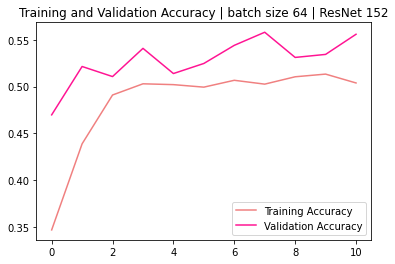

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, acc, color ='lightcoral', label='Training Accuracy')
plt.plot(epochs, val_acc, color = 'deeppink', label='Validation Accuracy')
plt.title('Training and Validation Accuracy | batch size 64 | ResNet 152')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

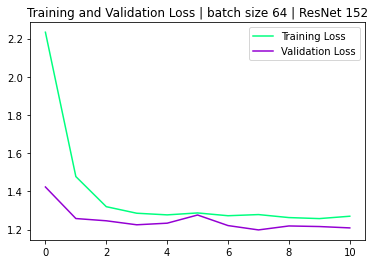

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, color='springgreen', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'darkviolet', label = 'Validation Loss')
plt.title('Training and Validation Loss | batch size 64 | ResNet 152')
plt.legend()
plt.figure()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
baseM7 = NASNetLarge(weights="imagenet", include_top=False, input_shape = (331, 331, 3)) ## 224, 224 size
#Freeze the NASNetLarge
for layer in baseM7.layers:
	layer.trainable = False

x = baseM7.output
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation="softmax")(x)

343621632/343610240 [==============================] - 4s 0us/step


In [ ]:
model = Model(baseM7.input, x)

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)
early_stopping = EarlyStopping(
    monitor='val_acc', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [ ]:
BATCH_SIZE = 64
NEPOCHS = 30
history = model.fit_generator(train_augment.flow(train_data, train_y, batch_size=BATCH_SIZE),
                              epochs = NEPOCHS, 
                              validation_data = valid_augment.flow(valid_data, valid_y),
                              verbose = 1, 
                              steps_per_epoch=(train_data.shape[0] // BATCH_SIZE), 
                              validation_steps=(valid_data.shape[0] // BATCH_SIZE), 
                              callbacks=[learning_rate_reduction, early_stopping])

#NasNet large

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/30
88/88 [==============================] - 197s 2s/step - loss: 2.5510 - acc: 0.4467 - val_loss: 1.1708 - val_acc: 0.5582 - lr: 1.0000e-04
Epoch 2/30
88/88 [==============================] - 165s 2s/step - loss: 1.2698 - acc: 0.5261 - val_loss: 1.0475 - val_acc: 0.6131 - lr: 1.0000e-04
Epoch 3/30
88/88 [==============================] - 166s 2s/step - loss: 1.1490 - acc: 0.5621 - val_loss: 1.0216 - val_acc: 0.6078 - lr: 1.0000e-04
Epoch 4/30
88/88 [==============================] - 167s 2s/step - loss: 1.1102 - acc: 0.5812 - val_loss: 1.0159 - val_acc: 0.6196 - lr: 1.0000e-04
Epoch 5/30
88/88 [==============================] - 167s 2s/step - loss: 1.0928 - acc: 0.5898 - val_loss: 0.9870 - val_acc: 0.6369 - lr: 1.0000e-04
Epoch 6/30
88/88 [==============================] - 167s 2s/step - loss: 1.0669 - acc: 0.5937 - val_loss: 0.9518 - val_acc: 0.6595 - lr: 1.0000e-04
Epoch 7/30
88/88 [==============================] - 167s 2s/step - loss: 1.0479 - acc: 0.6032 - val_loss: 0.9763

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

<Figure size 432x288 with 0 Axes>

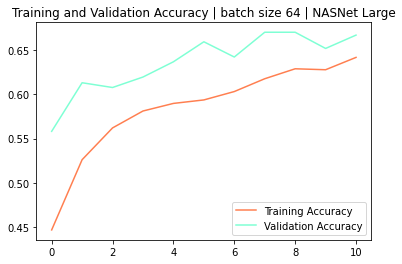

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, acc, color ='coral', label='Training Accuracy')
plt.plot(epochs, val_acc, color = 'aquamarine', label='Validation Accuracy')
plt.title('Training and Validation Accuracy | batch size 64 | NASNet Large')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

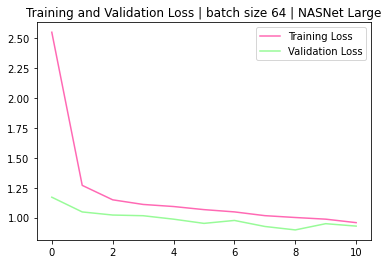

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, color='hotpink', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'palegreen', label = 'Validation Loss')
plt.title('Training and Validation Loss | batch size 64 | NASNet Large')
plt.legend()
plt.figure()

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 331, 331, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 165, 165, 96  2592        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 165, 165, 96  384         ['stem_conv1[0][0]']             
                                )                                                           

In [ ]:
baseM8 = EfficientNetB7(weights="imagenet", include_top=False, input_shape = (224, 224, 3)) ## 224, 224 size
# EfficientNetB7
for layer in baseM8.layers:
	layer.trainable = False

x = baseM8.output
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation="softmax")(x)

258088960/258076736 [==============================] - 7s 0us/step


In [ ]:
model = Model(baseM8.input, x)

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)
early_stopping = EarlyStopping(
    monitor='val_acc', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [ ]:
BATCH_SIZE = 64
NEPOCHS = 30
history = model.fit_generator(train_augment.flow(train_data, train_y, batch_size=BATCH_SIZE),
                              epochs = NEPOCHS, 
                              validation_data = valid_augment.flow(valid_data, valid_y),
                              verbose = 1, 
                              steps_per_epoch=(train_data.shape[0] // BATCH_SIZE), 
                              validation_steps=(valid_data.shape[0] // BATCH_SIZE), 
                              callbacks=[learning_rate_reduction, early_stopping])

# EfficientNetB7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/30
88/88 [==============================] - 185s 2s/step - loss: 2.6785 - acc: 0.3843 - val_loss: 1.3571 - val_acc: 0.4666 - lr: 1.0000e-04
Epoch 2/30
88/88 [==============================] - 151s 2s/step - loss: 1.3977 - acc: 0.4408 - val_loss: 1.3595 - val_acc: 0.4763 - lr: 1.0000e-04
Epoch 3/30
88/88 [==============================] - 151s 2s/step - loss: 1.3966 - acc: 0.4535 - val_loss: 1.3398 - val_acc: 0.4806 - lr: 1.0000e-04
Epoch 4/30
88/88 [==============================] - 150s 2s/step - loss: 1.4035 - acc: 0.4426 - val_loss: 1.3510 - val_acc: 0.4720 - lr: 1.0000e-04
Epoch 5/30
88/88 [==============================] - 150s 2s/step - loss: 1.3970 - acc: 0.4524 - val_loss: 1.3519 - val_acc: 0.4688 - lr: 1.0000e-04
Epoch 6/30
88/88 [==============================] - 151s 2s/step - loss: 1.3994 - acc: 0.4696 - val_loss: 1.3277 - val_acc: 0.4881 - lr: 1.0000e-04
Epoch 7/30
88/88 [==============================] - 150s 2s/step - loss: 1.3835 - acc: 0.4700 - val_loss: 1.3349

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

<Figure size 432x288 with 0 Axes>

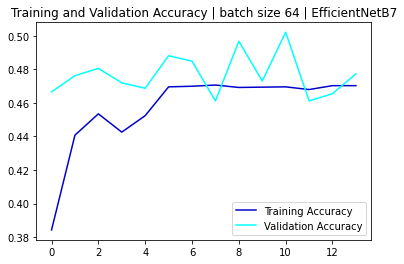

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, acc, color ='mediumblue', label='Training Accuracy')
plt.plot(epochs, val_acc, color = 'aqua', label='Validation Accuracy')
plt.title('Training and Validation Accuracy | batch size 64 | EfficientNetB7')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

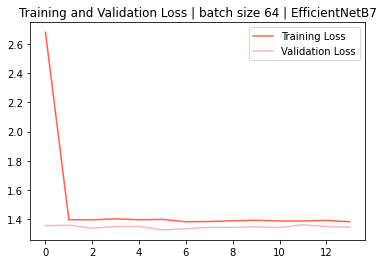

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, color='tomato', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'lightpink', label = 'Validation Loss')
plt.title('Training and Validation Loss | batch size 64 | EfficientNetB7')
plt.legend()
plt.figure()

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']    

In [ ]:
#InceptionV3
baseM = InceptionV3(weights="imagenet", include_top=False, input_shape = (224, 224, 3)) ## 224, 224 size
#Freeze the Inception V3 layers:
for layer in baseM.layers:
	layer.trainable = False

x = baseM.output
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation="softmax")(x)

87924736/87910968 [==============================] - 3s 0us/step


In [ ]:
model = Model(baseM.input, x)

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)
early_stopping = EarlyStopping(
    monitor='val_acc', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [ ]:
BATCH_SIZE = 64
NEPOCHS = 30
history = model.fit_generator(train_augment.flow(train_data, train_y, batch_size=BATCH_SIZE),
                              epochs = NEPOCHS, 
                              validation_data = valid_augment.flow(valid_data, valid_y),
                              verbose = 1, 
                              steps_per_epoch=(train_data.shape[0] // BATCH_SIZE), 
                              validation_steps=(valid_data.shape[0] // BATCH_SIZE), 
                              callbacks=[learning_rate_reduction, early_stopping])

# InceptionV3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/30
88/88 [==============================] - 85s 878ms/step - loss: 1.9541 - acc: 0.4387 - val_loss: 1.0978 - val_acc: 0.5981 - lr: 1.0000e-04
Epoch 2/30
88/88 [==============================] - 72s 819ms/step - loss: 1.2321 - acc: 0.5349 - val_loss: 1.0502 - val_acc: 0.5927 - lr: 1.0000e-04
Epoch 3/30
88/88 [==============================] - 71s 810ms/step - loss: 1.1538 - acc: 0.5601 - val_loss: 1.0159 - val_acc: 0.6088 - lr: 1.0000e-04
Epoch 4/30
88/88 [==============================] - 72s 816ms/step - loss: 1.1153 - acc: 0.5749 - val_loss: 1.0156 - val_acc: 0.6207 - lr: 1.0000e-04
Epoch 5/30
88/88 [==============================] - 72s 815ms/step - loss: 1.0851 - acc: 0.5849 - val_loss: 0.9226 - val_acc: 0.6573 - lr: 1.0000e-04
Epoch 6/30
88/88 [==============================] - 72s 811ms/step - loss: 1.0658 - acc: 0.5950 - val_loss: 0.9753 - val_acc: 0.6315 - lr: 1.0000e-04
Epoch 7/30
88/88 [==============================] - 71s 800ms/step - loss: 1.0571 - acc: 0.6001 - va

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

<Figure size 432x288 with 0 Axes>

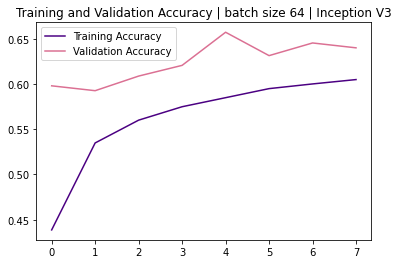

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, acc, color ='indigo', label='Training Accuracy')
plt.plot(epochs, val_acc, color = 'palevioletred', label='Validation Accuracy')
plt.title('Training and Validation Accuracy | batch size 64 | Inception V3')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

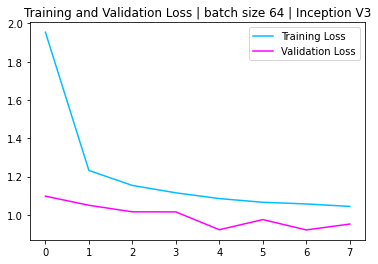

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, color='deepskyblue', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'magenta', label = 'Validation Loss')
plt.title('Training and Validation Loss | batch size 64 | Inception V3')
plt.legend()
plt.figure()

In [ ]:
#InceptionV3
baseM = InceptionV3(weights="imagenet", include_top=False, input_shape = (224, 224, 3)) ## 224, 224 size
#Freeze the Inception V3 layers:
for layer in baseM.layers:
	layer.trainable = False

x = baseM.output
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation="softmax")(x)

In [ ]:
model = Model(baseM.input, x)

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)
early_stopping = EarlyStopping(
    monitor='val_acc', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [ ]:
BATCH_SIZE = 64
NEPOCHS = 30
history = model.fit_generator(train_augment.flow(train_data, train_y, batch_size=BATCH_SIZE),
                              epochs = NEPOCHS, 
                              validation_data = valid_augment.flow(valid_data, valid_y),
                              verbose = 1, 
                              steps_per_epoch=(train_data.shape[0] // BATCH_SIZE), 
                              validation_steps=(valid_data.shape[0] // BATCH_SIZE), 
                              callbacks=[learning_rate_reduction, early_stopping])

# InceptionV3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/30
88/88 [==============================] - 93s 887ms/step - loss: 1.9172 - acc: 0.4338 - val_loss: 1.1267 - val_acc: 0.5862 - lr: 1.0000e-04
Epoch 2/30
88/88 [==============================] - 73s 830ms/step - loss: 1.2106 - acc: 0.5386 - val_loss: 1.0320 - val_acc: 0.6056 - lr: 1.0000e-04
Epoch 3/30
88/88 [==============================] - 74s 841ms/step - loss: 1.1382 - acc: 0.5715 - val_loss: 0.9574 - val_acc: 0.6207 - lr: 1.0000e-04
Epoch 4/30
88/88 [==============================] - 73s 831ms/step - loss: 1.1022 - acc: 0.5839 - val_loss: 1.0063 - val_acc: 0.6153 - lr: 1.0000e-04
Epoch 5/30
88/88 [==============================] - 73s 833ms/step - loss: 1.0820 - acc: 0.5910 - val_loss: 0.9460 - val_acc: 0.6433 - lr: 1.0000e-04
Epoch 6/30
88/88 [==============================] - 73s 830ms/step - loss: 1.0666 - acc: 0.6005 - val_loss: 0.9400 - val_acc: 0.6466 - lr: 1.0000e-04
Epoch 7/30
88/88 [==============================] - 74s 837ms/step - loss: 1.0372 - acc: 0.6010 - va

In [ ]:
#VGG19 
baseM9 = VGG19(weights="imagenet", include_top=False, input_shape = (224, 224, 3)) ## 224, 224 size
#Freeze the Inception V3 layers:
for layer in baseM9.layers:
	layer.trainable = False

x = baseM9.output
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation="softmax")(x)

In [ ]:
model = Model(baseM9.input, x)

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)
early_stopping = EarlyStopping(
    monitor='val_acc', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [ ]:
BATCH_SIZE = 64
NEPOCHS = 30
history = model.fit_generator(train_augment.flow(train_data, train_y, batch_size=BATCH_SIZE),
                              epochs = NEPOCHS, 
                              validation_data = valid_augment.flow(valid_data, valid_y),
                              verbose = 1, 
                              steps_per_epoch=(train_data.shape[0] // BATCH_SIZE), 
                              validation_steps=(valid_data.shape[0] // BATCH_SIZE), 
                              callbacks=[learning_rate_reduction, early_stopping])

# VGG19

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/30
88/88 [==============================] - 118s 1s/step - loss: 1.3818 - acc: 0.4873 - val_loss: 1.1022 - val_acc: 0.5690 - lr: 1.0000e-04
Epoch 2/30
88/88 [==============================] - 85s 966ms/step - loss: 1.1777 - acc: 0.5578 - val_loss: 1.0624 - val_acc: 0.5916 - lr: 1.0000e-04
Epoch 3/30
88/88 [==============================] - 85s 969ms/step - loss: 1.1054 - acc: 0.5891 - val_loss: 1.0146 - val_acc: 0.6185 - lr: 1.0000e-04
Epoch 4/30
88/88 [==============================] - 86s 977ms/step - loss: 1.0767 - acc: 0.6003 - val_loss: 0.9909 - val_acc: 0.6401 - lr: 1.0000e-04
Epoch 5/30
88/88 [==============================] - 86s 974ms/step - loss: 1.0526 - acc: 0.6039 - val_loss: 0.9595 - val_acc: 0.6369 - lr: 1.0000e-04
Epoch 6/30
88/88 [==============================] - 85s 966ms/step - loss: 1.0351 - acc: 0.6111 - val_loss: 0.9865 - val_acc: 0.6261 - lr: 1.0000e-04
Epoch 7/30
88/88 [==============================] - ETA: 0s - loss: 1.0231 - acc: 0.6187
Epoch 00007: 

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

<Figure size 432x288 with 0 Axes>

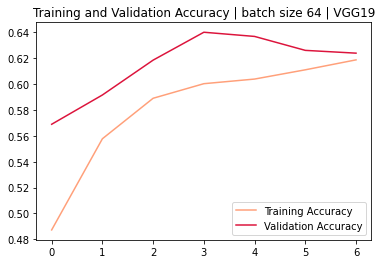

<Figure size 432x288 with 0 Axes>

In [ ]:

plt.plot(epochs, acc, color ='lightsalmon', label='Training Accuracy')
plt.plot(epochs, val_acc, color = 'crimson', label='Validation Accuracy')
plt.title('Training and Validation Accuracy | batch size 64 | VGG19')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

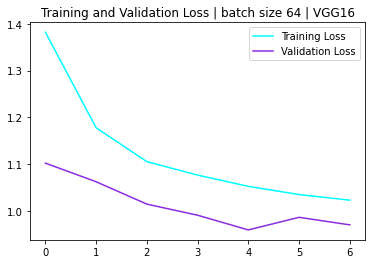

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, color='cyan', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'blueviolet', label = 'Validation Loss')
plt.title('Training and Validation Loss | batch size 64 | VGG19')
plt.legend()
plt.figure()

In [ ]:
model.summary( ) # VGG19

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# VGG 16
baseM10 = VGG16(weights="imagenet", include_top=False, input_shape = (224, 224, 3)) ## 224, 224 size
#Freeze the Inception V3 layers:
for layer in baseM10.layers:
	layer.trainable = False

x = baseM10.output
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation="softmax")(x)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
model = Model(baseM10.input, x)

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)
early_stopping = EarlyStopping(
    monitor='val_acc', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [ ]:
BATCH_SIZE = 64
NEPOCHS = 30
history = model.fit_generator(train_augment.flow(train_data, train_y, batch_size=BATCH_SIZE),
                              epochs = NEPOCHS, 
                              validation_data = valid_augment.flow(valid_data, valid_y),
                              verbose = 1, 
                              steps_per_epoch=(train_data.shape[0] // BATCH_SIZE), 
                              validation_steps=(valid_data.shape[0] // BATCH_SIZE), 
                              callbacks=[learning_rate_reduction, early_stopping])

# VGG16

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/30
88/88 [==============================] - 84s 941ms/step - loss: 1.4890 - acc: 0.4565 - val_loss: 1.1430 - val_acc: 0.5916 - lr: 1.0000e-04
Epoch 2/30
88/88 [==============================] - 82s 926ms/step - loss: 1.2095 - acc: 0.5454 - val_loss: 1.0086 - val_acc: 0.6110 - lr: 1.0000e-04
Epoch 3/30
88/88 [==============================] - 82s 927ms/step - loss: 1.1312 - acc: 0.5722 - val_loss: 0.9923 - val_acc: 0.6562 - lr: 1.0000e-04
Epoch 4/30
88/88 [==============================] - 81s 921ms/step - loss: 1.0747 - acc: 0.5955 - val_loss: 1.0274 - val_acc: 0.6045 - lr: 1.0000e-04
Epoch 5/30
88/88 [==============================] - 81s 923ms/step - loss: 1.0336 - acc: 0.6132 - val_loss: 0.9728 - val_acc: 0.6272 - lr: 1.0000e-04
Epoch 6/30
88/88 [==============================] - ETA: 0s - loss: 1.0172 - acc: 0.6162
Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Restoring model weights from the end of the best epoch: 3.
88/88 [===============

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

<Figure size 432x288 with 0 Axes>

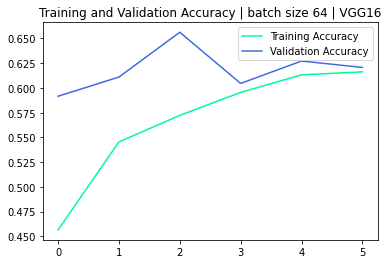

<Figure size 432x288 with 0 Axes>

In [ ]:

plt.plot(epochs, acc, color ='mediumspringgreen', label='Training Accuracy')
plt.plot(epochs, val_acc, color = 'royalblue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy | batch size 64 | VGG16')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

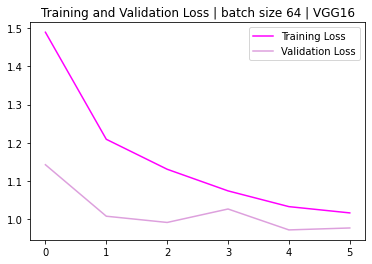

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, color='fuchsia', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'plum', label = 'Validation Loss')
plt.title('Training and Validation Loss | batch size 64 | VGG16')
plt.legend()
plt.figure()

In [ ]:
model.summary() # vgg16

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   